In [3]:
# -*- coding:utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CategoricalDQNNet(nn.Module):

    def __init__(self, config):
        super(CategoricalDQNNet, self).__init__()
        # TODO subsume the n_observations and n_actions to the config
        self.config = config
        self.input_dim = 4
        self.action_dim = 2
        self.num_atoms = 10
        output_dim = self.action_dim * self.num_atoms

        self.atoms = torch.linspace(
            0,
            1,
            self.num_atoms,
        )  # Z

        self.layer1 = nn.Linear(self.input_dim, 24)
        self.layer2 = nn.Linear(24, output_dim)
        self.reshape_layer = lambda x: x.view(-1, self.action_dim, self.num_atoms)  # Lambda layer for reshaping

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        x = self.reshape_layer(x)
        x = F.softmax(x, dim=-1)
        print("DEBUG #1: ", x.shape)
        #print("DEBUG #1.5: ", x[:5, :, :])
        #print("DEBUG #1.75: ", torch.sum(x[:5, :, :], dim=2))

        action_values = torch.tensordot(x, self.atoms, dims=1)
        print("DEBUG #2: ", action_values.shape)
        #print("DEBUG #2.5: ", action_values) 
        # Create an index of the max action value in each batch
        idx = torch.argmax(action_values, dim=1).to(torch.int64)
        print("DEBUG #3: ", idx.shape)
        #print("DEBUG #3.5: ", idx)
        # x and idx must share the same shape except for dimension 1 when using torch.gather
        idx = idx.view(x.shape[0], 1, 1).expand(-1, -1, self.num_atoms)
        print("DEBUG #4: ", idx.shape)
        #print("DEBUG #4.5: ", idx)

        # Adjust the index to: [[0, 1], [1, 0], [2, 1], [3, 1], etc.]
        # First number is row (batch) number, second number is the argmax index
        
        #idx = torch.stack((torch.arange(x.shape[0]), idx), dim=1)
        # Gather probability histogram for actions with max action values
        actorNet_output_argmax = torch.gather(x, dim=1, index=idx).squeeze(1)
        #print("DEBUG #5: ", actorNet_output_argmax.shape)

        return x, actorNet_output_argmax

In [30]:
from src.utils.config import Config
import gym

game = 'CartPole-v1'

env = gym.make(game)
config = Config(env)
Batchsize = 20
x = torch.randn((Batchsize, 4))

net  = CategoricalDQNNet(config)

x, actorNet_output_argmax = net(x)

DEBUG #1:  torch.Size([20, 2, 10])
DEBUG #2:  torch.Size([20, 2])
DEBUG #3:  torch.Size([20])
DEBUG #4:  torch.Size([20, 1, 10])


In [5]:
# -*- coding:utf-8 -*-
from src.utils.replay_memory import ReplayMemory, Transition
from src.utils.visualization import plot_durations
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from src.network.CategoricalDQN_net import *
from itertools import count
import random
import math
import torch
import matplotlib.pyplot as plt

In [ ]:
class CategoricalDQNAgent:

    def __init__(self, config):
        self.config = config 
        self.input_dim = config.input_dim
        self.action_dim = config.action_dim
        self.vmin = config.categorical_Vmin
        self.vmax = config.categorical_Vmax
        self.n_atoms = config.categorical_n_atoms
        
        self.atoms = torch.linspace(
            float(self.vmin),
            float(self.vmax),
            self.n_atoms,
        )  # Z

        self.total_steps = 0
        self.num_episodes = config.num_episodes
        self.steps = config.steps
        self.BATCH_SIZE = config.BATCH_SIZE
        self.GAMMA = config.GAMMA
        self.LR = config.LR
        self.TAU = config.TAU
        self.device = config.device

        self.env = None
        # copying weights of base_net to policy_net and target_net
        self.policy_net = CategoricalDQNNet(self.config)
        self.target_net = CategoricalDQNNet(self.config)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)
        self.criterion = nn.CrossEntropyLoss()

        self.replay_buffer_size = config.replay_buffer_size
        self.replay_memory = ReplayMemory(self.replay_buffer_size)

        self.delta_z = (config.categorical_Vmax - config.categorical_Vmin) / float(config.categorical_n_atoms - 1)
        
        self.episode_durations = []
        self.check_model_improved = torch.tensor([0])
        self.best_max = torch.tensor([0])

        # for select action (epsilon-greedy)
        self.steps_done = 0

        # VISUALISATION
        # plt.ion()
        # # Create a figure and axis object
        # self.fig, self.ax = plt.subplots()

        # # Initialize a line object on the axis; for example, starting with no data
        # self.line, = self.ax.plot([], [], 'r-')  # 'r-' is the color and line style (red line)

        # # Set axis limits
        # self.ax.set_xlim(0, 10)
        # self.ax.set_ylim(-1, 1)
        # Function to update the plot
    

    # def update_plot(self, x, y):
    #     self.line.set_xdata(x)
    #     self.line.set_ydata(y)
    #     self.ax.relim()  # Recalculate limits
    #     self.ax.autoscale_view(True, True, True)  # Autoscale view based on the data
    #     self.fig.canvas.draw()  # Redraw the figure
    #     self.fig.canvas.flush_events()  # Process GUI events


def transition(self):
        """
        In transition, the agent simply plays and records
        [current_state, action, reward, next_state, done]
        in the replay_memory

        Updating the weights of the neural network happens
        every single time the replay buffer size is reached.

        done: boolean, whether the game has ended or not.
        """
        for i_episode in range(self.num_episodes):
            state, info = self.env.reset() 
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)

            print('Episode: {} Reward: {} Max_Reward: {}'.format(i_episode, self.check_model_improved[0].item(), self.best_max[0].item()))
            print('-' * 64)
            self.check_model_improved = 0
            
            for t in count():
                # reshape the input state to a tensor ===> Network ===> action probabilities
                # size = (1, action dimension, number of atoms)
                # e.g. size = (1, 2, 51)
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                reward = torch.tensor([reward], device=self.device)
                done = terminated or truncated
    
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)

                # Store the transition in memory
                self.replay_memory.push(state, action, next_state, reward)

                # Move to the next state
                state = next_state
                self.total_steps += 1

                # Perform one step of the optimization (on the policy network)
                # Note difference in previous implementation -> cleared buffer after replay 
                # and waited until buffer size was reached instead of batch size
                # if len(self.replay_buffer) == self.replay_buffer_size:
                #     self.train_by_replay()
                #     self.replay_buffer.clear()
                self.train_by_replay()

                # Soft update of the target network's weights 
                # θ′ ← τ θ + (1 −τ )θ′
                # previous implementation updates were done for any episode where the reward is higher
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                self.target_net.load_state_dict(target_net_state_dict)

                if done:
                    self.episode_durations.append(t + 1)
                    #plot_durations(self)
                    break
                else:
                    self.check_model_improved += reward

            if self.check_model_improved > self.best_max:
                self.best_max = self.check_model_improved


def train_by_replay(self):
    """
    TD update by replaying the history.
    """
    # step 1: generate replay samples (size = self.batch_size) from the replay buffer
    # e.g. uniform random replay or prioritize experience replay NOTE (for now only uniform replay)
    if len(self.replay_memory) < self.BATCH_SIZE:
        return
    transitions = self.replay_memory.sample(self.BATCH_SIZE)

    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which the imulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), device=self.device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    action_prob_next = torch.zeros(self.BATCH_SIZE, self.action_dim, self.n_atoms, device=self.device)
    with torch.no_grad():
        action_prob_next[non_final_mask], _ = self.target_net(non_final_next_states)
        action_value_next = torch.tensordot(action_prob_next, self.atoms, dims=1)
        action_next = np.argmax(action_value_next, axis=1)
        
        #print("DEBUG: 2: action_prob_next.shape", action_prob_next.shape)
        # use the optimal actions as index, pick out the probabilities of the optimal action
        prob_next = action_prob_next[np.arange(self.BATCH_SIZE), action_next, :]

        # match the rewards from the memory to the same size as the prob_next
        reshaped_reward_batch = torch.tile(reward_batch.reshape(self.BATCH_SIZE, 1), (1, self.n_atoms))
    
    # perform TD update 
    discount = self.GAMMA * non_final_mask
    print("DEBUG #3: ", discount.shape)
    # check do I really need to reshape discount again? TODO 
    atoms_next = reshaped_reward_batch + torch.from_numpy(np.dot(discount.reshape(self.BATCH_SIZE, 1),
                                    self.atoms.reshape(1, self.n_atoms)))
    # constrain atoms_next to be within Vmin and Vmax
    atoms_next = torch.clip(atoms_next, self.vmin, self.vmax)
    # calculate the floors and ceilings of atom_next
    b = (atoms_next - self.vmin) / self.delta_z
    l, u = torch.floor(b).int(), torch.ceil(b).int()
    # it is important to check if l == u, to avoid histogram collapsing.
    d_m_l = (u + (l == u) - b) * prob_next
    d_m_u = (b - l) * prob_next

    # redistribute the target probability histogram (calculation of m)
    # NOTE that there is an implementation issue
    # The loss function requires current histogram and target histogram to have the same size
    # Generally, the loss function should be the categorical cross entropy loss between
    # P(x, a*): size = (32, 1, 51) and P(x(t+1), a*): size = (32, 1, 51), i.e. only for optimal actions
    # However, the network generates P(x, a): size = (32, 2, 51), i.e. for all actions
    # Therefore, I create a tensor with zeros (size = (32, 2, 51)) and update only the probability histogram
    target_histo = torch.zeros(self.BATCH_SIZE, self.n_atoms)

    for i in range(self.BATCH_SIZE):
        target_histo[i][action_next[i]] = 0.0  # clear the histogram that needs to be updated
        for j in range(l[i].size(0)):
            target_histo[i, l[i][j]] += d_m_l[i][j]  # Update d_m_l
            target_histo[i, l[i][j]] += d_m_u[i][j]  # Update d_m_u

    _, histo = self.policy_net(state_batch)
    
    # print("DEBUG: 3: histo.shape, target_histo.shape", histo.shape, target_histo.shape)
    # Compute CrossEntropyLoss
    loss = self.criterion(histo, target_histo)
    #print("DEBGGING histo:", histo[0], torch.sum(histo[0])) TODO D
    #print("DEBGGING target_histo:", target_histo[0], torch.sum(target_histo[0])) TODO D
    
    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
    self.optimizer.step()

def eval_step(self, render=True):
    """
    Evaluation using the trained target network, no training involved
    :param render: whether to visualize the evaluation or not
    """
    for each_ep in range(self.config.evaluate_episodes):
        state, info = self.env.reset() 
        state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)

        print('Episode: {} Reward: {} Training_Max_Reward: {}'.format(each_ep, self.check_model_improved[0].item(),
                                                                        self.best_max[0].item()))
        print('-' * 64)
        self.check_model_improved = 0

        for t in count():
            action = self.select_action(self, state)
            observation, reward, terminated, truncated, _ = self.env.step(action.item())
            reward = torch.tensor([reward], device=self.device)
            done = terminated or truncated 

            if render:
                self.env.render()

            if done:
                break
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)  
                state = next_state
                self.check_model_improved += reward
    
    print('Complete')
    # plot_durations(self, show_result=True)


# NOTE Create an abstract class of Agents with this method
def select_action(self, state):
    sample = random.random()
    eps_threshold = self.config.EPS_END + (self.config.EPS_START - self.config.EPS_END) * \
        math.exp(-1. * self.steps_done / self.config.EPS_DECAY)
    self.steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # reshape the input state to a tensor ===> Network ===> action probabilities
            # size = (1, action dimension, number of atoms)
            # e.g. size = (1, 2, 51)
            action_prob, _ = self.policy_net(state)
            action_values = torch.tensordot(action_prob, self.atoms, dims=1)
            # print("DEBUG: 1: action_values in action selection: ", action_values[0]) TODO D

            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            max_actions = action_values.max(1).indices.view(1, 1)
            print("DEBUG #1: ", max_actions[0, :])
            return max_actions
    else:
        return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)

In [2]:
def moving_average(time_series, window_size=20):
    # Initialize the list with zeros for the first 100 elements
    averaged_series = [0] * min(window_size, len(time_series))
    
    # Compute the moving average for each position in the series
    for i in range(window_size, len(time_series)):
        # Calculate the average of the last 100 elements from the current position
        average = (sum(time_series[i-window_size:i]) / window_size)
        if type(average) != type(0.0):
            average = average[0]
        averaged_series.append(average)
    
    return averaged_series

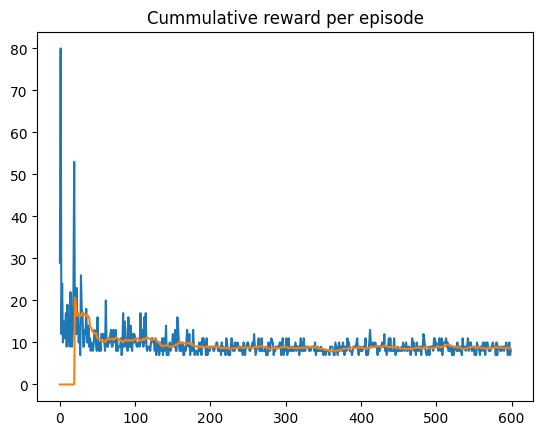

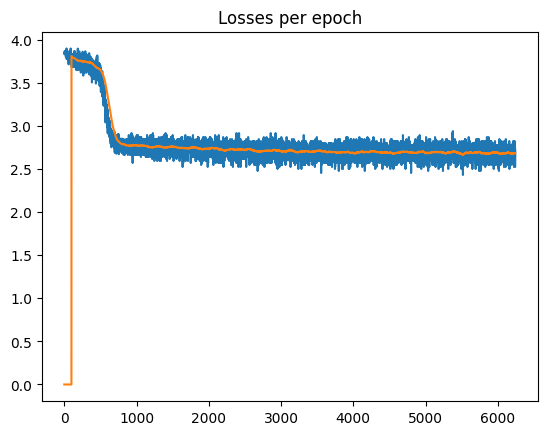

In [5]:
import numpy as np
import matplotlib.pyplot as plt

rewards = np.load("rewards.npy")
losses = np.load("losses.npy").tolist()
# unpacking the elements of losses that are numpy arrays
#losses = [loss[0] for loss in losses]

reward_average = moving_average(rewards)
loss_average = moving_average(losses, window_size=100)

plt.plot(rewards)
plt.plot(reward_average)
plt.title("Cummulative reward per episode")
plt.show()

plt.plot(losses)
plt.plot(loss_average)
plt.title("Losses per epoch")
plt.show()